In [ ]:
# Setting up a custom stylesheet in IJulia
file = open("style.css") # A .css file in the same folder as this notebook file
styl = read(file, String) # Read the file
HTML("$styl") # Output as HTML

<h1> SIR models of disease dynamics </h1>

<h2>In this lecture</h2>

- [Outcome](#Outcome)
- [SIR Models: the concepts](#SIR-Models:-the-concepts)
- [SIR Models: the equations](#SIR-Models:-the-equations)
- [Julia code: the function for one time-step](#Julia-code:-the-function-for-one-time-step)
- [Julia code: the loop structure](#Julia-code:-the-loop-structure)
- [Running the model](#Running-the-model)
- [Plotting the results](#Plotting-the-results)


[Back to the top](#In-this-lecture)

<h2>Outcome</h2>

After this lecture, you will be able to
- Define the compartments S, I and R of an SIR
- Formulate an SIR model for infectious diseases
- Write a ``for`` loop to for an SIR model 
- Plot the curves for S(t), I(t) and R(t)

[Back to the top](#In-this-lecture)

<h2>SIR Models: the concepts</h2>

SIR models formalise what is probably the simplest possible way to think of an epidemic: 
- before the epidemic starts, there is a population at risk of catching the disease
- the disease spreads from infected to susceptible people
- after a while, people are no longer infected
- once infected, people are never infected again
- we ignore all other differences between people

We use the symbol $S$ for the number of people who are still at risk of the disease. "$S$" is short for "susceptible", meaning a person who hasn't had the disease and might catch it. We think of $S$ as a function of time, that is, we think that as the epidemic progresses, $S$ changes. Therefore we write $S(t)$ for the number of suseptibles at time $t$.

The number $S(0)$, which is the number of susceptibles at the start of the epidemic, is a key value in this model.

The number of infected people at time $t$ is given by $I(t)$. We assume that $I(0) > 0$, because otherwise the epidemic can't start.

Finally, the people previously infected but no longer infectious are called "removed". (Unfortunately, this doesn't mean they've recovered. They may still be ill, or as happens tragically often with Ebola, they may be dead). We use $R(t)$ to symbolise the number of removed people  at time $t$.




**NB! It is not necessary for S, I and R to be whole numbers.** This is a model, and all we want is for the predicted values of $S$, $I$ and $R$ to be close to what is observed. By close we mean within a few percent. In fact, because the models are so simple and the real situation so variable, getting numbers within a few percent is a major achievement.

Unfortunately, this is usually possible only with  hindsight. We will show that an SIR model can do pretty well for the 2014 West African EVD epidemic, but it will be with hindsight. The course of the epidemic was not successfully predicted until it was nearly over.

[Back to the top](#In-this-lecture)

<h2>SIR Models: the equations</h2>

We will model $S$, $I$ and $R$ in discrete time steps. In fact, we will use the same length of time step $dt$ for every step. We denote by $t_i$ the time after $i$ steps. Since we assume that $t_0 = 0$, we have $t_i = i\,dt$.

The model steps from $t_i$ to $t_{i+1}$, so what we want to do is use the values of $S(t_i)$, $I(t_i)$ and $R(t_i)$ to predict the values $S(t_{i+1})$, $I(t_{i+1})$ and $R(t_{i+1})$. So our model is set up in terms of three equations.

These equations all have the form "new value = old value + gains - losses". The model specifies how we calculate the gains and losses.

For susceptibles, there is only a loss term. The simplest SIR models come from the so-called "law of mass action". This law holds that all susceptibles have an equal chance of meeting an infected person. And the same is assumed for infected people. Then the number of  meetings of infecteds and susceptibles is proportional to product $SI$. We use the symbol $\lambda$ for the constant of proportionality, and we interpret $\lambda SI$ as the rate at which susceptibles become infected. This is of course a rate per day. So the actual loss over the time step $dt$ is actually $\lambda SI\,dt$ so the equation for $S$ is

1 ...     $ S(t_{i+1}) = S(t_i) - \lambda S(t_i)I(t_i)\,dt$.

On the other hand, the loss rate for infected people is just a constant probability of recovery per unit time. So a constant fraction $\gamma$ is removed from the infecteds per day. This gives a loss of $\gamma I$ infecteds per day, which is $\gamma I\,dt$ loss of infecteds per time step. The gain of infecteds must be exactly the susceptibles who become infected, so the equation for $I$ is

2 ...     $I(t_{i+1}) = I(t_i) + \lambda S(t_i)I(t_i)\,dt - \gamma I(t_i)\,dt$.

In an SIR model, the removed population equation has only a gain term, no loss term. What is lost from infecteds is gained by removeds, so the equation for $R$ is

3 ...     $R(t_{i+1}) = R(t_i) + \gamma I(t_i)\,dt$.

Our discrete SIR model consists of equations 1, 2 and 3 for $S$, $I$, $R$.

[Back to the top](#In-this-lecture)

<h2>Julia code: the function for one time-step</h2>

So now we consider the best way to write the Julia code. We have several options: we could write a ``for`` loop with the three equations inside; we could make three functions, one for each of $S$, $I$ and $R$; we could combine all three into one array and write one function to update all three at the same time. We will do that here.

**Julia functions have access to all variables that are visible at the level that the function is created**

This feature of Julia will surprise many experienced programmers. If we assign a value to the variable ``b`` and then call a function that uses ``b`` without mentioning ``b`` in the argument of the function, the function will nevertheless use the value of ``b`` as needed. See below:


In [1]:
b = 7;
f(x) = b*x
f(6)

42

We will use this feature to pass the values of $\lambda$ and $\gamma$ to the updating function. That is, in writing the code for the function, we pass it only the $S$, $I$, $R$ arguments and take the parameter values from the context in which the function is called. This is actually amazingly convenient, especially when we want to experiment with different parameter values for  the sake of fitting the model output to the data.

This means the function looks like this:

In [2]:
function updateSIR(popnvector)       # some liberty here: using upper case in the function name
    susceptibles = popnvector[1];
    infecteds    = popnvector[2]; 
    removeds     = popnvector[3];
    newS = susceptibles - lambda*susceptibles*infecteds*dt
    newI = infecteds + lambda*susceptibles*infecteds*dt - gam*infecteds*dt  #note abbreviation for gamma (see below)
    newR = removeds + gam*infecteds*dt
    return [newS newI newR]   # NB! spaces only to make this a one row of a two-dimensional array
    #                   and note the use of "return" to specify what the function output should be 
end

updateSIR (generic function with 1 method)

One should always do at least minimal checking that a function works as expected. 

For professional code, one should do extensive checking, both of output and input ... one should in fact write the function so that if it fails, it fails  gracefully, and give it some protection against error conditions. But we're not writing professional code!


In [3]:
# first we set the parameters
dt = 0.5                    # so we are taking two steps per day
lambda = 1/200; gam = 1/10  #note that gamma is a function in the stats packages, so let's not use it as a name

# then we specify the input vector to the function
s, i, r = 1000., 10, 20  # multiple assignment
vec = [s i r]         # followed by creating the input vector; spaces again so that it is a row of an array
updateSIR(vec)        # finally the actual function call to test the function

1×3 Array{Float64,2}:
 975.0  34.5  20.5

[Back to the top](#In-this-lecture)

<h2>Julia code: the loop structure</h2>

Now we consider the loop structure. We can't run the model indefinitely, of course, so there has to be a definite end time $T_f$. We will use $T_f=610$ days, which is just a little more than the number of epidemic days in the data from Wikipedia.

The number of steps is then in principle $n = T_f/dt$, but here is a delicate moment in the use of computers. Computer arithmetic is not infinitely precise, and so we cannot be quite sure that if we use the computer to calculate $n$ in this way that we will exactly have $n\,dt = T_f$ as we expect on the grounds of algebra. I like to set time as a separate variable, to keep explicit track of step number $i$, and to continue for $n$ steps. Then if at the end the time is not exactly $T_f$ it doesn't matter, because it will be extremely close to it.

The take-home message is DO NOT RELY ON EXACT EQUALITY, even if you can reasonably expect it. Computers normally are only very close to the numbers you, the programmer, are thinking of (excluding again the exactness that professional programmers may sometimes achieve).

Knowing the value of $n$ also allows us to initialise an array to hold all the values as they're collected, one row of three elements for each value of the time. This will end up being $n+1$ values, of course.

So here is the concept code:

In [6]:
tfinal = 610;    # respecting community values: lowercase only in the names 
nsteps = round(Int64, tfinal/dt)    # note the use of round() with type Int64 to ensure that nsteps is an integer
resultvals = Array{Float64}(undef, nsteps+1, 3)  #initialise array of type Float64 to hold results
timevec = Array{Float64}(undef, nsteps+1)        # ... ditto for time values

# specify the initial values S(0), I(0), R(0)
# resultvals[1,:] = [s0, i0, r0]  # ... and assign them to the first row

for step  = 1:nsteps
    # call updateSIR with the step vals and load result into resultvals[step+1, :]  
    # update time and load it into timevec
end

I like to write out concept code like this, making sure I understand how the loops work, how the logical steps (say using ``if``) work, what the main variables are, and so on, before the fine detail. 

The next step is to add all the missing details, and then we can run the model.

[Back to the top](#In-this-lecture)

<h2>Running the model</h2>

We can now run the model. First let us go over the full code we want to run.

In [7]:
# set the values that define the current run
lambda = 1/20000   # infection rate parameter (assumes rates are per day)
gam = 1/10       # recovery rate parameter  (ditto)
dt = 0.5         # length of time step in days
tfinal = 610;    # respecting community values: lowercase only in the names 
s0 = 10000.0     # initial susceptibles, note that we use the  type Float64 from the start
i0 = 4.          # initial infecteds; set this to 1. to  mimic an epidemic with an index case
r0 = 0.          # not always the case, of course

# initialise the current run
nsteps = round(Int64, tfinal/dt)    # note the use of round() with type Int64 to ensure that nsteps is an integer
resultvals = Array{Float64}(undef, nsteps+1, 3)  #initialise array of type Float64 to hold results
timevec = Array{Float64}(undef, nsteps+1)        # ... ditto for time values
resultvals[1,:] = [s0, i0, r0]  # ... and assign them to the first row
timevec[1] = 0.                 # also Float64, of course.

# execute the current run
for step  = 1:nsteps
    resultvals[step+1, :] = updateSIR(resultvals[step, :])  # NB! pay careful attention to the rows being used
    timevec[step+1] = timevec[step] + dt
end

[Back to the top](#In-this-lecture)

<h2>Plotting the results</h2>

It is now simple  to plot the three population components versus the time.



In [8]:
using Plots
gr()

Plots.GRBackend()

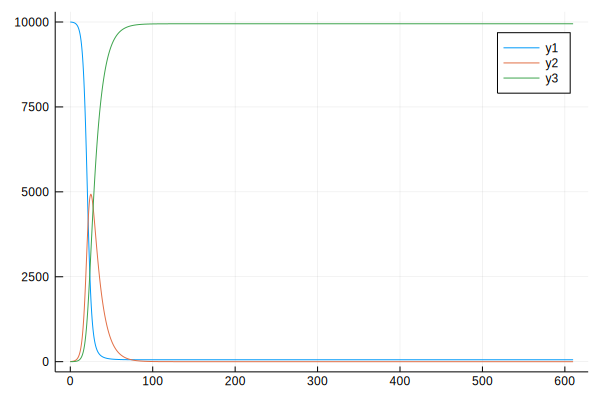

In [9]:
plot(timevec, resultvals)  # quick and dirty! Plots ought to interpret this as we mean it ...

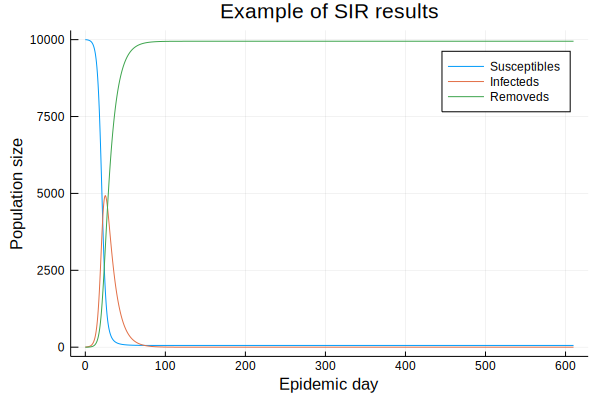

In [10]:
plot(timevec, resultvals,  # we should of course at a minimum provide some labels
title  = "Example of SIR results",
xlabel = "Epidemic day",
ylabel = "Population size",
label  = ["Susceptibles" "Infecteds" "Removeds"]
)

Now we can see that the susceptible start at 10,000 and they drop very quickly. The infected start at very near zero, they rise very very quickly. We see that here it's less than 50 days. So they peak, at about half of the total population are infected at the same time but then they die out very quickly. You can see here that the infected line is slightly below the susceptible line. So a few people were never infected. Similarly, the removes are slightly below the 10,000 initial value because a few people were never infected. The number of infected go down to zero of course because there's no more infections happening. So this is an illustration of how an SIR model produces output. Of course this is totally unrealistic for the Ebola virus disease numbers that we saw before. So what we need to do is to go on to try and adapt this model to give us the kind of output that was actually seen in Ebola, and then see whether when we discussed that, anything of insight, anything significant can be said about the Ebola virus disease epidemic.

[Back to the top](#In-this-lecture)